In [1]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
%matplotlib inline
plt.style.use('seaborn')
from scipy.ndimage.filters import gaussian_filter1d
import os
from google.colab import files

# Load Initial Data

In [ ]:
BASE_DIR = '/content/drive/My Drive/4th Year/CS 197 (Thesis)/FINAL - COVID Modeling/notebooks'
file_path = os.path.join(BASE_DIR, 'data/normalized_5day_moving.csv')
moved_scaled = pd.read_csv(file_path, index_col=0)
moved_scaled['Province/State'] = moved_scaled['Province/State'].fillna('no province')
moved_scaled['area']=moved_scaled['Province/State']+" "+moved_scaled['Country/Region']
moved_scaled.head()

In [ ]:
moved_scaled.shape

(263, 459)

### Load Graphs

In [ ]:
def get_graphs(df, areas=['no province Philippines'], startc=7):
  fig=plt.figure(figsize=(50,20))
  ax=fig.add_axes([0,0,1,1])
  ax.set_xlabel("Dates")
  ax.set_ylabel("Cases")
  for area in areas:
    try:
        df_area = df[df['area'] == area]
        x = df_area.columns[startc:]
        y=[]
        for i in x:
          y.append(df_area[i].values.sum())
        
        ax.plot(x,y,label=area)
        #comment out the line below to remove the labels of the area names.
        #ax.legend()
    except IndexError:
        # No South Korea in the dataset
        print("area is not in the dataset")
        
get_graphs(moved_scaled, areas=moved_scaled['area'])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Single country / Multiple countries
def get_graph(df, country='Philippines', index=None, startc=7, endc=None):
  try:
    if index:
      df_country = df.loc[index]
    else:
      if isinstance(country, str):
        df_country = df[df['Country/Region'] == country]
      else:
        df_country = df[df['Country/Region'].isin(country)]
  
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    fig.suptitle(df_country['area'].values[0], fontsize=16)
    ax.set_xlabel("Dates")
    ax.set_ylabel("Cases")
    ax.get_xaxis().set_ticks([])
    # ax.get_yaxis().set_ticks([])

    if endc:
      x = df_country.columns[startc:-endc]
    else:
      x = df_country.columns[startc:]
    y = df_country[x]

    for idx, row in y.iterrows():
      ax.plot(x, row)

    fig.legend(df_country['area'])

    # ax.plot(x,y)
  except IndexError:
    # No South Korea in the dataset
    print("Country is not in the dataset")

In [ ]:
import math

# Multiple countries
def compare_graphs(df, range_of_index=(0,10), num_rows=4, figsize=(10,10)):
  start_index = range_of_index[0]
  end_index = range_of_index[1]
  df_country = df.loc[start_index:end_index]
  num_cols = math.ceil(df_country.shape[0] / num_rows)

  fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
  fig.suptitle('Countries from {} to {}'.format(df_country.loc[start_index, 'area'], df_country.loc[end_index, 'area'], fontsize=16))
  x = df.columns[7:]
  ctr = 0

  for i in range(num_rows):
    for j in range(num_cols):
      if start_index + ctr <= end_index:
        try:
          curr_country = df_country.loc[start_index + ctr]
          y = [curr_country[i] for i in x]
          axs[i, j].plot(x, y)
          axs[i, j].set_title(curr_country['area'])
          axs[i, j].get_xaxis().set_ticks([])
          axs[i, j].get_yaxis().set_ticks([])
          ctr += 1
        except KeyError:
          axs[i, j].axis('off')
      else:
        axs[i, j].axis('off')

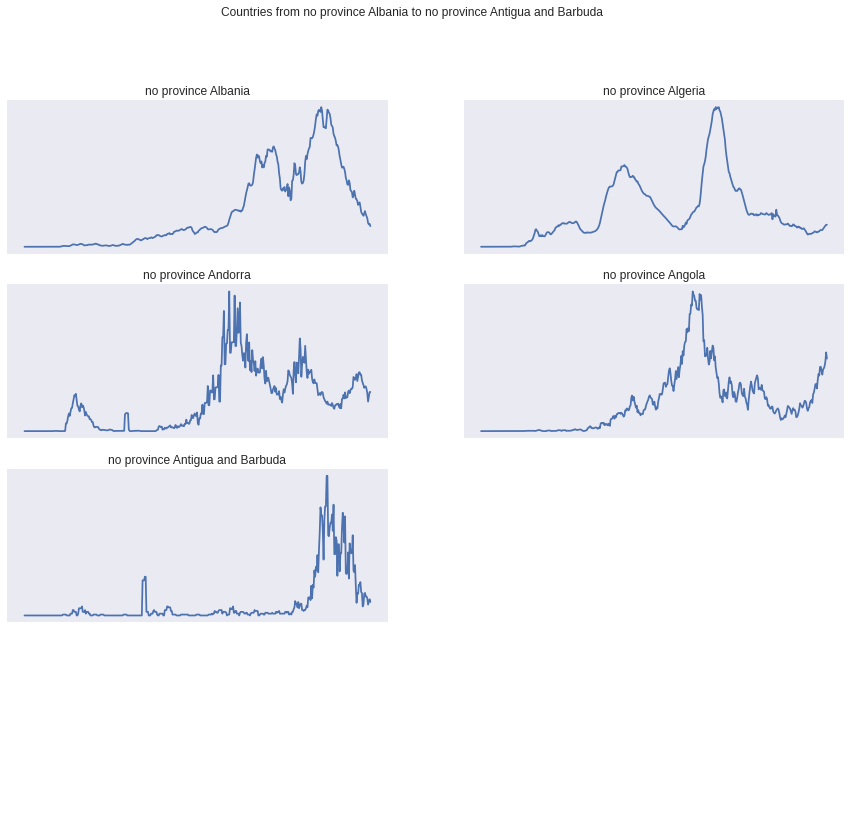

In [ ]:
compare_graphs(moved_scaled, range_of_index=(1,5), figsize=(15,13))

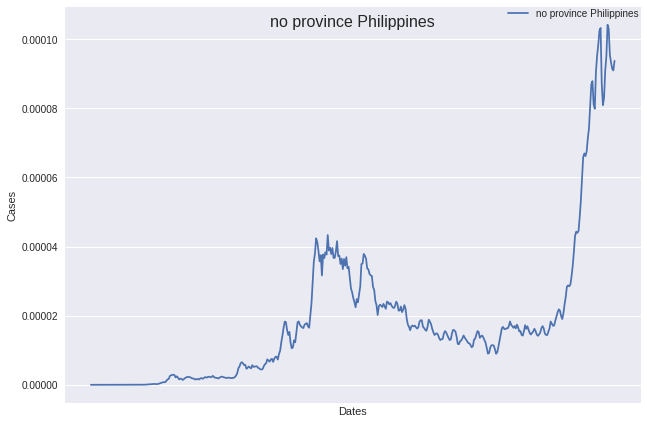

In [ ]:
get_graph(moved_scaled, country='Philippines')

# Removing Outliers

In [ ]:
df_daily_confirmed = pd.read_csv(
    os.path.join(BASE_DIR, 'data/daily_confirmed_filtered.csv'), index_col=0)

def get_total(df):
  df['total_cases'] = df.iloc[:, -1]
  df['Province/State'] = df['Province/State'].fillna('no province')
  df['area'] = df['Province/State'] + ' ' + df['Country/Region']
  columns = list(df.columns)
  columns = columns[:4] + columns[-2:] + columns[4:-2]
  df = df[columns]
  return df

df_daily_confirmed = get_total(df_daily_confirmed)
df_daily_confirmed.head()

Province/State Country/Region       Lat  ...  4/16/21  4/17/21 4/18/21
0    no province    Afghanistan  33.93911  ...       78      109      72
1    no province        Albania  41.15330  ...      179      149     138
2    no province        Algeria  28.03390  ...      181      163     156
3    no province        Andorra  42.50630  ...       71       59      34
4    no province         Angola -11.20270  ...      171      178      89

[5 rows x 460 columns]

In [ ]:
def move_last_cols_to_first(df, num_cols, start_col=7):
  columns = list(df.columns)
  columns = columns[:start_col] + columns[-num_cols:] + columns[start_col:-num_cols]
  df = df[columns]
  return df

In [ ]:
dates_cols = df_daily_confirmed.columns[7:]
df_daily_confirmed['peak_cases'] = df_daily_confirmed[dates_cols].max(axis=1)
df_daily_confirmed['normalized_peak'] = df_daily_confirmed['peak_cases'] / df_daily_confirmed['populations']
df_daily_confirmed = move_last_cols_to_first(df_daily_confirmed, 2)
df_daily_confirmed.head()

Province/State Country/Region       Lat  ...  4/16/21  4/17/21 4/18/21
0    no province    Afghanistan  33.93911  ...       78      109      72
1    no province        Albania  41.15330  ...      179      149     138
2    no province        Algeria  28.03390  ...      181      163     156
3    no province        Andorra  42.50630  ...       71       59      34
4    no province         Angola -11.20270  ...      171      178      89

[5 rows x 462 columns]

In [ ]:
df_outliers = df_daily_confirmed[df_daily_confirmed['peak_cases'] < 500]
df_outliers.head()

Province/State       Country/Region  ...  4/17/21  4/18/21
3                   no province              Andorra  ...       59       34
4                   no province               Angola  ...      178       89
5                   no province  Antigua and Barbuda  ...        3        0
8  Australian Capital Territory            Australia  ...        0        0
9               New South Wales            Australia  ...        6        8

[5 rows x 462 columns]

In [ ]:
df_outliers['area'].values.tolist()

['no province Andorra',
 'no province Angola',
 'no province Antigua and Barbuda',
 'Australian Capital Territory Australia',
 'New South Wales Australia',
 'Northern Territory Australia',
 'Queensland Australia',
 'South Australia Australia',
 'Tasmania Australia',
 'Western Australia Australia',
 'no province Bahamas',
 'no province Barbados',
 'no province Bhutan',
 'no province Brunei',
 'no province Burkina Faso',
 'no province Burundi',
 'no province Cabo Verde',
 'Diamond Princess Canada',
 'Grand Princess Canada',
 'New Brunswick Canada',
 'Newfoundland and Labrador Canada',
 'Northwest Territories Canada',
 'Nova Scotia Canada',
 'Prince Edward Island Canada',
 'Yukon Canada',
 'no province Central African Republic',
 'no province Chad',
 'Anhui China',
 'Beijing China',
 'Chongqing China',
 'Fujian China',
 'Gansu China',
 'Guangdong China',
 'Guangxi China',
 'Guizhou China',
 'Hainan China',
 'Hebei China',
 'Heilongjiang China',
 'Henan China',
 'Hong Kong China',
 'Hunan 

In [ ]:
moved_scaled = moved_scaled[~moved_scaled['area'].isin(df_outliers['area'])]
moved_scaled.head()

Province/State Country/Region       Lat  ...   4/16/21   4/17/21   4/18/21
0    no province    Afghanistan  33.93911  ...  0.000002  0.000002  0.000002
1    no province        Albania  41.15330  ...  0.000064  0.000065  0.000059
2    no province        Algeria  28.03390  ...  0.000004  0.000004  0.000004
6    no province      Argentina -38.41610  ...  0.000558  0.000556  0.000509
7    no province        Armenia  40.06910  ...  0.000289  0.000314  0.000301

[5 rows x 459 columns]

# Confirmed

## Smoothing Curves

In [ ]:
new_dates = moved_scaled.columns[6:]
new_moved_scaled = moved_scaled.copy()
new_moved_scaled

Province/State      Country/Region        Lat  ...   4/16/21   4/17/21   4/18/21
0      no province         Afghanistan  33.939110  ...  0.000002  0.000002  0.000002
1      no province             Albania  41.153300  ...  0.000064  0.000065  0.000059
2      no province             Algeria  28.033900  ...  0.000004  0.000004  0.000004
6      no province           Argentina -38.416100  ...  0.000558  0.000556  0.000509
7      no province             Armenia  40.069100  ...  0.000289  0.000314  0.000301
..             ...                 ...        ...  ...       ...       ...       ...
258    no province          Uzbekistan  41.377491  ...  0.000007  0.000007  0.000008
259    no province           Venezuela   6.423800  ...  0.000040  0.000043  0.000044
261    no province  West Bank and Gaza  31.952200  ...  0.000392  0.000349  0.000313
263    no province              Zambia -13.133897  ...  0.000008  0.000008  0.000008
264    no province            Zimbabwe -19.015438  ...  0.000003  0.000005  0.000006

[140 rows x 459 columns]

In [ ]:
new_moved_scaled.shape

(140, 459)

### Stack 7-day moving average for 5 times on all countries

In [ ]:
"""
# Old version of doing moving average
def Moving_Ave_Stack(dff, days, times):
    NUM_DAYS = days
    new_dff = dff.copy()
    if times>0:
        
        dates = new_dff.columns[6:]
        for idx, date in enumerate(dates):
            seven_days = dates[idx : idx+NUM_DAYS]
            new_dff[date] = new_dff.apply(lambda x: x[seven_days].mean(), axis=1)
        times=times-1
        return Moving_Ave_Stack(new_dff, days, times)
    else:
        return new_dff
"""

# Slightly better way of doing a moving average using Pandas' rolling average
def get_moving_average(df, window_size, col_start=6):
  return pd.concat([
                    df[df.columns[:col_start]], 
                    df[df.columns[col_start:]].apply(
                        lambda x: x.rolling(window_size, axis=0).mean(), axis=1
                        ).fillna(0, axis=1)
                    ], axis=1)

def Moving_Ave_Stack(df, window_size, times, col_start=6):
  new_df = df.copy()
  for _ in range(times):
    new_df = get_moving_average(new_df, window_size, col_start)
  
  return new_df

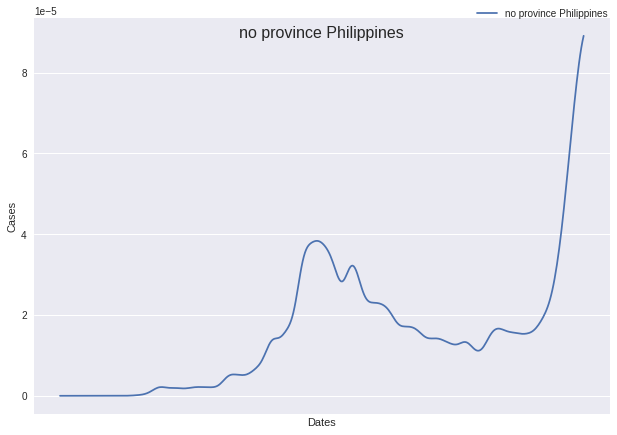

In [ ]:
smoothen_moved_scaled = Moving_Ave_Stack(new_moved_scaled, 7, 5)
get_graph(smoothen_moved_scaled, country='Philippines')

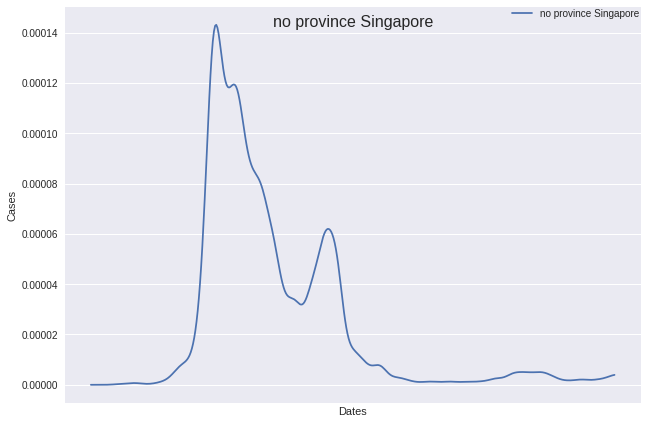

In [ ]:
get_graph(smoothen_moved_scaled, country='Singapore')

In [ ]:
smoothen_moved_scaled.head()

Province/State Country/Region       Lat  ...   4/16/21   4/17/21   4/18/21
0    no province    Afghanistan  33.93911  ...  0.000001  0.000001  0.000001
1    no province        Albania  41.15330  ...  0.000129  0.000125  0.000120
2    no province        Algeria  28.03390  ...  0.000002  0.000003  0.000003
6    no province      Argentina -38.41610  ...  0.000264  0.000277  0.000292
7    no province        Armenia  40.06910  ...  0.000308  0.000307  0.000307

[5 rows x 459 columns]

In [ ]:
get_graphs(smoothen_moved_scaled, areas=smoothen_moved_scaled['area'])

Output hidden; open in https://colab.research.google.com to view.

## Normalize by Peak

In [ ]:
def normalize_peak(df, start_col=6):
  smoothen_moved_scaled = df.copy()
  new_dates = df.columns[start_col:]
  peak = smoothen_moved_scaled[new_dates].to_numpy().max()
  print(peak)

  for col in new_dates:
    smoothen_moved_scaled[col] = smoothen_moved_scaled[col] / peak
  
  return smoothen_moved_scaled

In [ ]:
smoothen_moved_scaled = normalize_peak(smoothen_moved_scaled)
smoothen_moved_scaled.head()

0.0017158444607138993


Province/State Country/Region       Lat  ...   4/16/21   4/17/21   4/18/21
0    no province    Afghanistan  33.93911  ...  0.000661  0.000708  0.000757
1    no province        Albania  41.15330  ...  0.075096  0.072598  0.070098
2    no province        Algeria  28.03390  ...  0.001451  0.001471  0.001493
6    no province      Argentina -38.41610  ...  0.153746  0.161645  0.170205
7    no province        Armenia  40.06910  ...  0.179394  0.179190  0.178827

[5 rows x 459 columns]

In [ ]:
get_graphs(smoothen_moved_scaled, areas=smoothen_moved_scaled['area'])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# (smoothen_moved_scaled[new_dates].max(axis=1) == 1).argmax()
smoothen_moved_scaled.loc[16]

Province/State    no province
Country/Region        Austria
Lat                   47.5162
Long                  14.5501
populations           9006398
                     ...     
4/14/21              0.204831
4/15/21               0.20361
4/16/21              0.201817
4/17/21              0.199492
4/18/21              0.196707
Name: 16, Length: 459, dtype: object

In [ ]:
smoothen_moved_scaled.shape

(140, 459)

## Saving as CSV

In [ ]:
smoothen_moved_scaled.to_csv(os.path.join(BASE_DIR, 'data/new_normalized_confirmed.csv'))

# Deaths

In [ ]:
file_path = os.path.join(BASE_DIR, 'data/time_series_covid19_deaths_global.csv')
deaths = pd.read_csv(file_path)
deaths = deaths.drop(deaths.columns[-1], axis=1)
deaths.head()

Province/State Country/Region       Lat  ...  4/16/21  4/17/21  4/18/21
0            NaN    Afghanistan  33.93911  ...     2535     2539     2539
1            NaN        Albania  41.15330  ...     2337     2340     2342
2            NaN        Algeria  28.03390  ...     3148     3152     3155
3            NaN        Andorra  42.50630  ...      123      123      123
4            NaN         Angola -11.20270  ...      560      561      561

[5 rows x 457 columns]

In [ ]:
columns = deaths.columns

In [ ]:
# Copies the specified columns into a new Dataframe
daily_deaths = deaths.copy()
print(len(columns))

for i in range(5, len(columns)):
    daily = deaths[columns[i]] - deaths[columns[i-1]]
    daily_deaths[columns[i]]=daily

daily_deaths.head()

457


Province/State Country/Region       Lat  ...  4/16/21  4/17/21  4/18/21
0            NaN    Afghanistan  33.93911  ...        2        4        0
1            NaN        Albania  41.15330  ...        2        3        2
2            NaN        Algeria  28.03390  ...        4        4        3
3            NaN        Andorra  42.50630  ...        2        0        0
4            NaN         Angola -11.20270  ...        3        1        0

[5 rows x 457 columns]

In [ ]:
# Combine province/state and country into one column
daily_deaths['Province/State']=daily_deaths['Province/State'].fillna("no province")
daily_deaths['area']=daily_deaths['Province/State']+" "+daily_deaths['Country/Region']
daily_deaths.head()

Province/State Country/Region  ...  4/18/21                     area
0    no province    Afghanistan  ...        0  no province Afghanistan
1    no province        Albania  ...        2      no province Albania
2    no province        Algeria  ...        3      no province Algeria
3    no province        Andorra  ...        0      no province Andorra
4    no province         Angola  ...        0       no province Angola

[5 rows x 458 columns]

In [ ]:
daily_deaths = daily_deaths.copy()
cols = daily_deaths.columns.tolist()
cols = cols[:4] + cols[-1::] + cols[4:-1]
daily_deaths = daily_deaths[cols]
daily_deaths.head()

Province/State Country/Region       Lat  ...  4/16/21 4/17/21  4/18/21
0    no province    Afghanistan  33.93911  ...        2       4        0
1    no province        Albania  41.15330  ...        2       3        2
2    no province        Algeria  28.03390  ...        4       4        3
3    no province        Andorra  42.50630  ...        2       0        0
4    no province         Angola -11.20270  ...        3       1        0

[5 rows x 458 columns]

### Normalize by Population

In [ ]:
daily_death_rate = pd.merge(daily_deaths, moved_scaled[moved_scaled.columns[4:6]], on='area')
print(daily_death_rate.shape)
daily_death_rate.head()

(140, 459)


Province/State Country/Region       Lat  ...  4/17/21 4/18/21  populations
0    no province    Afghanistan  33.93911  ...        4       0     38928346
1    no province        Albania  41.15330  ...        3       2      2877797
2    no province        Algeria  28.03390  ...        4       3     43851044
3    no province      Argentina -38.41610  ...       80      64     45195774
4    no province        Armenia  40.06910  ...       24      19      2963243

[5 rows x 459 columns]

In [ ]:
cols = daily_death_rate.columns.tolist()
cols = cols[:5] + cols[-1::] + cols[5:-1]
daily_death_rate = daily_death_rate[cols]
daily_death_rate.head()

Province/State Country/Region       Lat  ...  4/16/21 4/17/21  4/18/21
0    no province    Afghanistan  33.93911  ...        2       4        0
1    no province        Albania  41.15330  ...        2       3        2
2    no province        Algeria  28.03390  ...        4       4        3
3    no province      Argentina -38.41610  ...      159      80       64
4    no province        Armenia  40.06910  ...       18      24       19

[5 rows x 459 columns]

In [ ]:
for col in daily_death_rate.columns[6:]:
    daily_death_rate[col]=daily_death_rate[col]/daily_death_rate['populations']
daily_death_rate.head()

Province/State Country/Region  ...       4/17/21       4/18/21
0    no province    Afghanistan  ...  1.027529e-07  0.000000e+00
1    no province        Albania  ...  1.042464e-06  6.949761e-07
2    no province        Algeria  ...  9.121790e-08  6.841342e-08
3    no province      Argentina  ...  1.770077e-06  1.416062e-06
4    no province        Armenia  ...  8.099235e-06  6.411894e-06

[5 rows x 459 columns]

In [ ]:
daily_death_rate.shape

(140, 459)

### Removing Negatives

In [ ]:
# this whole block deals with negatives by replacing them with the moving average--with that column as the center
def remove_negatives(df, mean_constant, start_col=6):
  df_copy = df.copy()
  columns = df_copy.columns
  for idx, col in enumerate(columns[START_COL:], start=START_COL):
    if (df_copy[col] < 0).any():
      neg_cols = df_copy[df_copy[col] < 0][col]
      for country_idx, value in neg_cols.items():
        surrounding = pd.concat([df_copy.loc[country_idx, columns[idx-MEAN_CONSTANT:idx]], 
                              df_copy.loc[country_idx, columns[idx+1:idx+1+MEAN_CONSTANT]]])
        curr_mean = int(surrounding[surrounding >= 0].mean())
        df_copy.loc[country_idx, col] = curr_mean
  
  return df_copy

In [ ]:
MEAN_CONSTANT = 4
START_COL = 6
daily_death_rate = remove_negatives(daily_death_rate, MEAN_CONSTANT)

In [ ]:
NUM_DAYS = 7
moving_ave_deaths = Moving_Ave_Stack(daily_death_rate, NUM_DAYS, times=5, col_start=6)
moving_ave_deaths.head()

Province/State Country/Region  ...       4/17/21       4/18/21
0    no province    Afghanistan  ...  9.472866e-08  9.647718e-08
1    no province        Albania  ...  2.812178e-06  2.753915e-06
2    no province        Algeria  ...  7.839301e-08  7.853548e-08
3    no province      Argentina  ...  3.163901e-06  3.342952e-06
4    no province        Armenia  ...  6.284593e-06  6.393000e-06

[5 rows x 459 columns]

## Normalize Deaths

In [ ]:
scaled_deaths = normalize_peak(moving_ave_deaths, start_col=6)
scaled_deaths.head()

2.647769620977774e-05


Province/State Country/Region       Lat  ...   4/16/21   4/17/21   4/18/21
0    no province    Afghanistan  33.93911  ...  0.003446  0.003578  0.003644
1    no province        Albania  41.15330  ...  0.108483  0.106209  0.104009
2    no province        Algeria  28.03390  ...  0.002954  0.002961  0.002966
3    no province      Argentina -38.41610  ...  0.113878  0.119493  0.126255
4    no province        Armenia  40.06910  ...  0.233164  0.237354  0.241448

[5 rows x 459 columns]

In [ ]:
get_graphs(scaled_deaths, areas=scaled_deaths['area'])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
scaled_deaths.shape

(140, 459)

## Removing Outlier Deaths

In [ ]:
scaled_deaths = scaled_deaths[~scaled_deaths['area'].isin(df_outliers['area'])]
scaled_deaths.head()

Province/State Country/Region       Lat  ...   4/16/21   4/17/21   4/18/21
0    no province    Afghanistan  33.93911  ...  0.003446  0.003578  0.003644
1    no province        Albania  41.15330  ...  0.108483  0.106209  0.104009
2    no province        Algeria  28.03390  ...  0.002954  0.002961  0.002966
3    no province      Argentina -38.41610  ...  0.113878  0.119493  0.126255
4    no province        Armenia  40.06910  ...  0.233164  0.237354  0.241448

[5 rows x 459 columns]

In [ ]:
# Remove the ones without a population
scaled_deaths = scaled_deaths.merge(df_daily_confirmed[df_daily_confirmed.columns[:2]], 
                                    how='inner', 
                                    on=['Country/Region', 'Province/State'])
scaled_deaths.head()

Province/State Country/Region       Lat  ...   4/16/21   4/17/21   4/18/21
0    no province    Afghanistan  33.93911  ...  0.003446  0.003578  0.003644
1    no province        Albania  41.15330  ...  0.108483  0.106209  0.104009
2    no province        Algeria  28.03390  ...  0.002954  0.002961  0.002966
3    no province      Argentina -38.41610  ...  0.113878  0.119493  0.126255
4    no province        Armenia  40.06910  ...  0.233164  0.237354  0.241448

[5 rows x 459 columns]

In [ ]:
scaled_deaths.shape

(140, 459)

## Saving as CSV

In [ ]:
scaled_deaths.to_csv(os.path.join(BASE_DIR, 'data/new_normalized_deaths.csv'))

## Old Method (death rate by previous infections)

###merge the different dataset first to get rid of countries with incomplete data

In [ ]:
scaled_deaths.head()

Province/State Country/Region       Lat  ...   2/13/21   2/14/21   2/15/21
0    no province    Afghanistan  33.93911  ...  0.000721  0.000670  0.000464
1    no province        Albania  41.15330  ...  0.003657  0.003451  0.003296
2    no province        Algeria  28.03390  ...  0.000876  0.000773  0.000876
3    no province        Andorra  42.50630  ...  0.000052  0.000052  0.000052
4    no province         Angola -11.20270  ...  0.000824  0.000721  0.000309

[5 rows x 396 columns]

In [ ]:
#deaths.head()
confi = pd.read_csv(os.path.join(BASE_DIR, 'data/time_series_covid19_confirmed_global.csv'))
reco = pd.read_csv(os.path.join(BASE_DIR, 'data/time_series_covid19_recovered_global.csv'))
confi['Province/State']=confi['Province/State'].fillna("no province")
confi['area']=confi['Province/State']+" "+confi['Country/Region']
cols = confi.columns.tolist()
cols = cols[:4] + cols[-1::] + cols[4:-1]
confi = confi[cols]
reco['Province/State']=reco['Province/State'].fillna("no province")
reco['area']=reco['Province/State']+" "+reco['Country/Region']
cols = reco.columns.tolist()
cols = cols[:4] + cols[-1::] + cols[4:-1]
reco = reco[cols]
deaths['Province/State']=deaths['Province/State'].fillna("no province")
deaths['area']=deaths['Province/State']+" "+deaths['Country/Region']
cols = deaths.columns.tolist()
cols = cols[:4] + cols[-1::] + cols[4:-1]
deaths = deaths[cols]
reco.head()

Province/State Country/Region       Lat  ...  2/14/21  2/15/21  2/16/21
0    no province    Afghanistan  33.93911  ...  48395.0  48433.0  48514.0
1    no province        Albania  41.15330  ...  56764.0  57736.0  58794.0
2    no province        Algeria  28.03390  ...  75999.0  76168.0  76330.0
3    no province        Andorra  42.50630  ...   9911.0   9965.0  10022.0
4    no province         Angola -11.20270  ...  18795.0  18884.0  18929.0

[5 rows x 397 columns]

In [ ]:
confi.head()

Province/State Country/Region       Lat  ...  2/14/21 2/15/21  2/16/21
0    no province    Afghanistan  33.93911  ...    55492   55514    55518
1    no province        Albania  41.15330  ...    93075   93850    94651
2    no province        Algeria  28.03390  ...   110711  110894   111069
3    no province        Andorra  42.50630  ...    10503   10538    10555
4    no province         Angola -11.20270  ...    20366   20381    20389

[5 rows x 397 columns]

In [ ]:
active_deaths = pd.merge(scaled_deaths, 'Country)

In [ ]:
active_cases = deaths.copy()
active_cases=pd.merge(active_cases, confi[confi.columns[4:]], on='area')
active_cases=pd.merge(active_cases, reco[confi.columns[4:]], on='area')
active_cases.shape

NameError: ignored

In [ ]:
active_cases.head()

Province/State Country/Region       Lat  ...  2/14/21  2/15/21  2/16/21
0    no province    Afghanistan  33.93911  ...  48395.0  48433.0  48514.0
1    no province        Albania  41.15330  ...  56764.0  57736.0  58794.0
2    no province        Algeria  28.03390  ...  75999.0  76168.0  76330.0
3    no province        Andorra  42.50630  ...   9911.0   9965.0  10022.0
4    no province         Angola -11.20270  ...  18795.0  18884.0  18929.0

[5 rows x 1181 columns]

In [ ]:
dates_length=392
info_length=5

In [ ]:
active_cases[active_cases.columns[5:info_length+dates_length]].head()

1/22/20_x  1/23/20_x  1/24/20_x  ...  2/14/21_x  2/15/21_x  2/16/21_x
0          0          0          0  ...       2427       2427       2428
1          0          0          0  ...       1555       1567       1582
2          0          0          0  ...       2939       2943       2945
3          0          0          0  ...        107        107        107
4          0          0          0  ...        492        493        494

[5 rows x 392 columns]

###Get active cases

In [ ]:
for i in (1, len(columns[4:])-1):
    active_cases[active_cases.columns[i+info_length]]=active_cases[active_cases.columns[i+info_length+dates_length]]-active_cases[active_cases.columns[i+info_length-1]]-active_cases[active_cases.columns[i+info_length+dates_length+dates_length-1]]
active_cases.head()

Province/State Country/Region       Lat  ...  2/14/21  2/15/21  2/16/21
0    no province    Afghanistan  33.93911  ...  48395.0  48433.0  48514.0
1    no province        Albania  41.15330  ...  56764.0  57736.0  58794.0
2    no province        Algeria  28.03390  ...  75999.0  76168.0  76330.0
3    no province        Andorra  42.50630  ...   9911.0   9965.0  10022.0
4    no province         Angola -11.20270  ...  18795.0  18884.0  18929.0

[5 rows x 1181 columns]

In [ ]:
scaled_deaths.head()

Province/State Country/Region       Lat  ...    2/14/21 2/15/21  2/16/21
0    no province    Afghanistan  33.93911  ...   0.333333     0.5      1.0
1    no province        Albania  41.15330  ...  13.000000    13.5     15.0
2    no province        Algeria  28.03390  ...   3.333333     3.0      2.0
3    no province        Andorra  42.50630  ...   0.000000     0.0      0.0
4    no province         Angola -11.20270  ...   1.000000     1.0      1.0

[5 rows x 397 columns]

In [ ]:
death_rate=pd.merge(active_cases[active_cases.columns[:info_length+dates_length]], scaled_deaths[scaled_deaths.columns[4:]], on='area')

In [ ]:
death_rate.head()

Province/State Country/Region       Lat  ...    2/14/21 2/15/21  2/16/21
0    no province    Afghanistan  33.93911  ...   0.333333     0.5      1.0
1    no province        Albania  41.15330  ...  13.000000    13.5     15.0
2    no province        Algeria  28.03390  ...   3.333333     3.0      2.0
3    no province        Andorra  42.50630  ...   0.000000     0.0      0.0
4    no province         Angola -11.20270  ...   1.000000     1.0      1.0

[5 rows x 789 columns]

In [ ]:
death_rate.shape

(213, 789)

In [ ]:
daily_columns = scaled_deaths.columns[info_length:]
for col in range(0, len(daily_columns)-1):
    death_rate[death_rate.columns[col+info_length+dates_length]] = death_rate[death_rate.columns[col+info_length+dates_length]] / death_rate[death_rate.columns[col+info_length]]
    death_rate[death_rate.columns[col+info_length+dates_length]].fillna(0)

death_rate[death_rate.columns[info_length+dates_length:]].head()

1/22/20  1/23/20  1/24/20  1/25/20  ...   2/13/21   2/14/21   2/15/21  2/16/21
0      NaN      NaN      NaN      NaN  ...  0.000412  0.000137  0.000206      1.0
1      NaN      NaN      NaN      NaN  ...  0.008263  0.008360  0.008615     15.0
2      NaN      NaN      NaN      NaN  ...  0.001107  0.001134  0.001019      2.0
3      NaN      NaN      NaN      NaN  ...  0.002336  0.000000  0.000000      0.0
4      NaN      NaN      NaN      NaN  ...  0.002037  0.002033  0.002028      1.0

[5 rows x 392 columns]

In [ ]:
pd.set_option('use_inf_as_na', True)
for col in death_rate.columns:
    death_rate[col].replace([np.inf, -np.inf], np.nan)
    death_rate[col].fillna(0, inplace=True)
death_rate[death_rate.columns[info_length+dates_length:]].head()

1/22/20  1/23/20  1/24/20  1/25/20  ...   2/13/21   2/14/21   2/15/21  2/16/21
0      0.0      0.0      0.0      0.0  ...  0.000412  0.000137  0.000206      1.0
1      0.0      0.0      0.0      0.0  ...  0.008263  0.008360  0.008615     15.0
2      0.0      0.0      0.0      0.0  ...  0.001107  0.001134  0.001019      2.0
3      0.0      0.0      0.0      0.0  ...  0.002336  0.000000  0.000000      0.0
4      0.0      0.0      0.0      0.0  ...  0.002037  0.002033  0.002028      1.0

[5 rows x 392 columns]

In [ ]:
peak2 = death_rate[death_rate.columns[info_length+dates_length:-1]].to_numpy().max()
peak2

3.0

###Filter out countries with faulty data with death rate higher than 1

In [ ]:
filtered_dr=death_rate.copy()
for cols in filtered_dr.columns[info_length+dates_length:-1]:
    filtered_dr=filtered_dr[filtered_dr[cols]<5]
filtered_dr[filtered_dr.columns[info_length+dates_length:-1]].shape

(213, 391)

In [ ]:
peak2 = filtered_dr[filtered_dr.columns[info_length+dates_length:-1]].to_numpy().max()
peak2

3.0

In [ ]:
for col in filtered_dr.columns[info_length+dates_length:-1]:
  filtered_dr[col] = filtered_dr[col] / peak2

filtered_dr.head()

Province/State Country/Region       Lat  ...   2/14/21   2/15/21  2/16/21
0    no province    Afghanistan  33.93911  ...  0.000046  0.000069      1.0
1    no province        Albania  41.15330  ...  0.002787  0.002872     15.0
2    no province        Algeria  28.03390  ...  0.000378  0.000340      2.0
3    no province        Andorra  42.50630  ...  0.000000  0.000000      0.0
4    no province         Angola -11.20270  ...  0.000678  0.000676      1.0

[5 rows x 789 columns]

In [ ]:
peak2 = filtered_dr[filtered_dr.columns[info_length+dates_length:-1]].to_numpy().max()
peak2

1.0

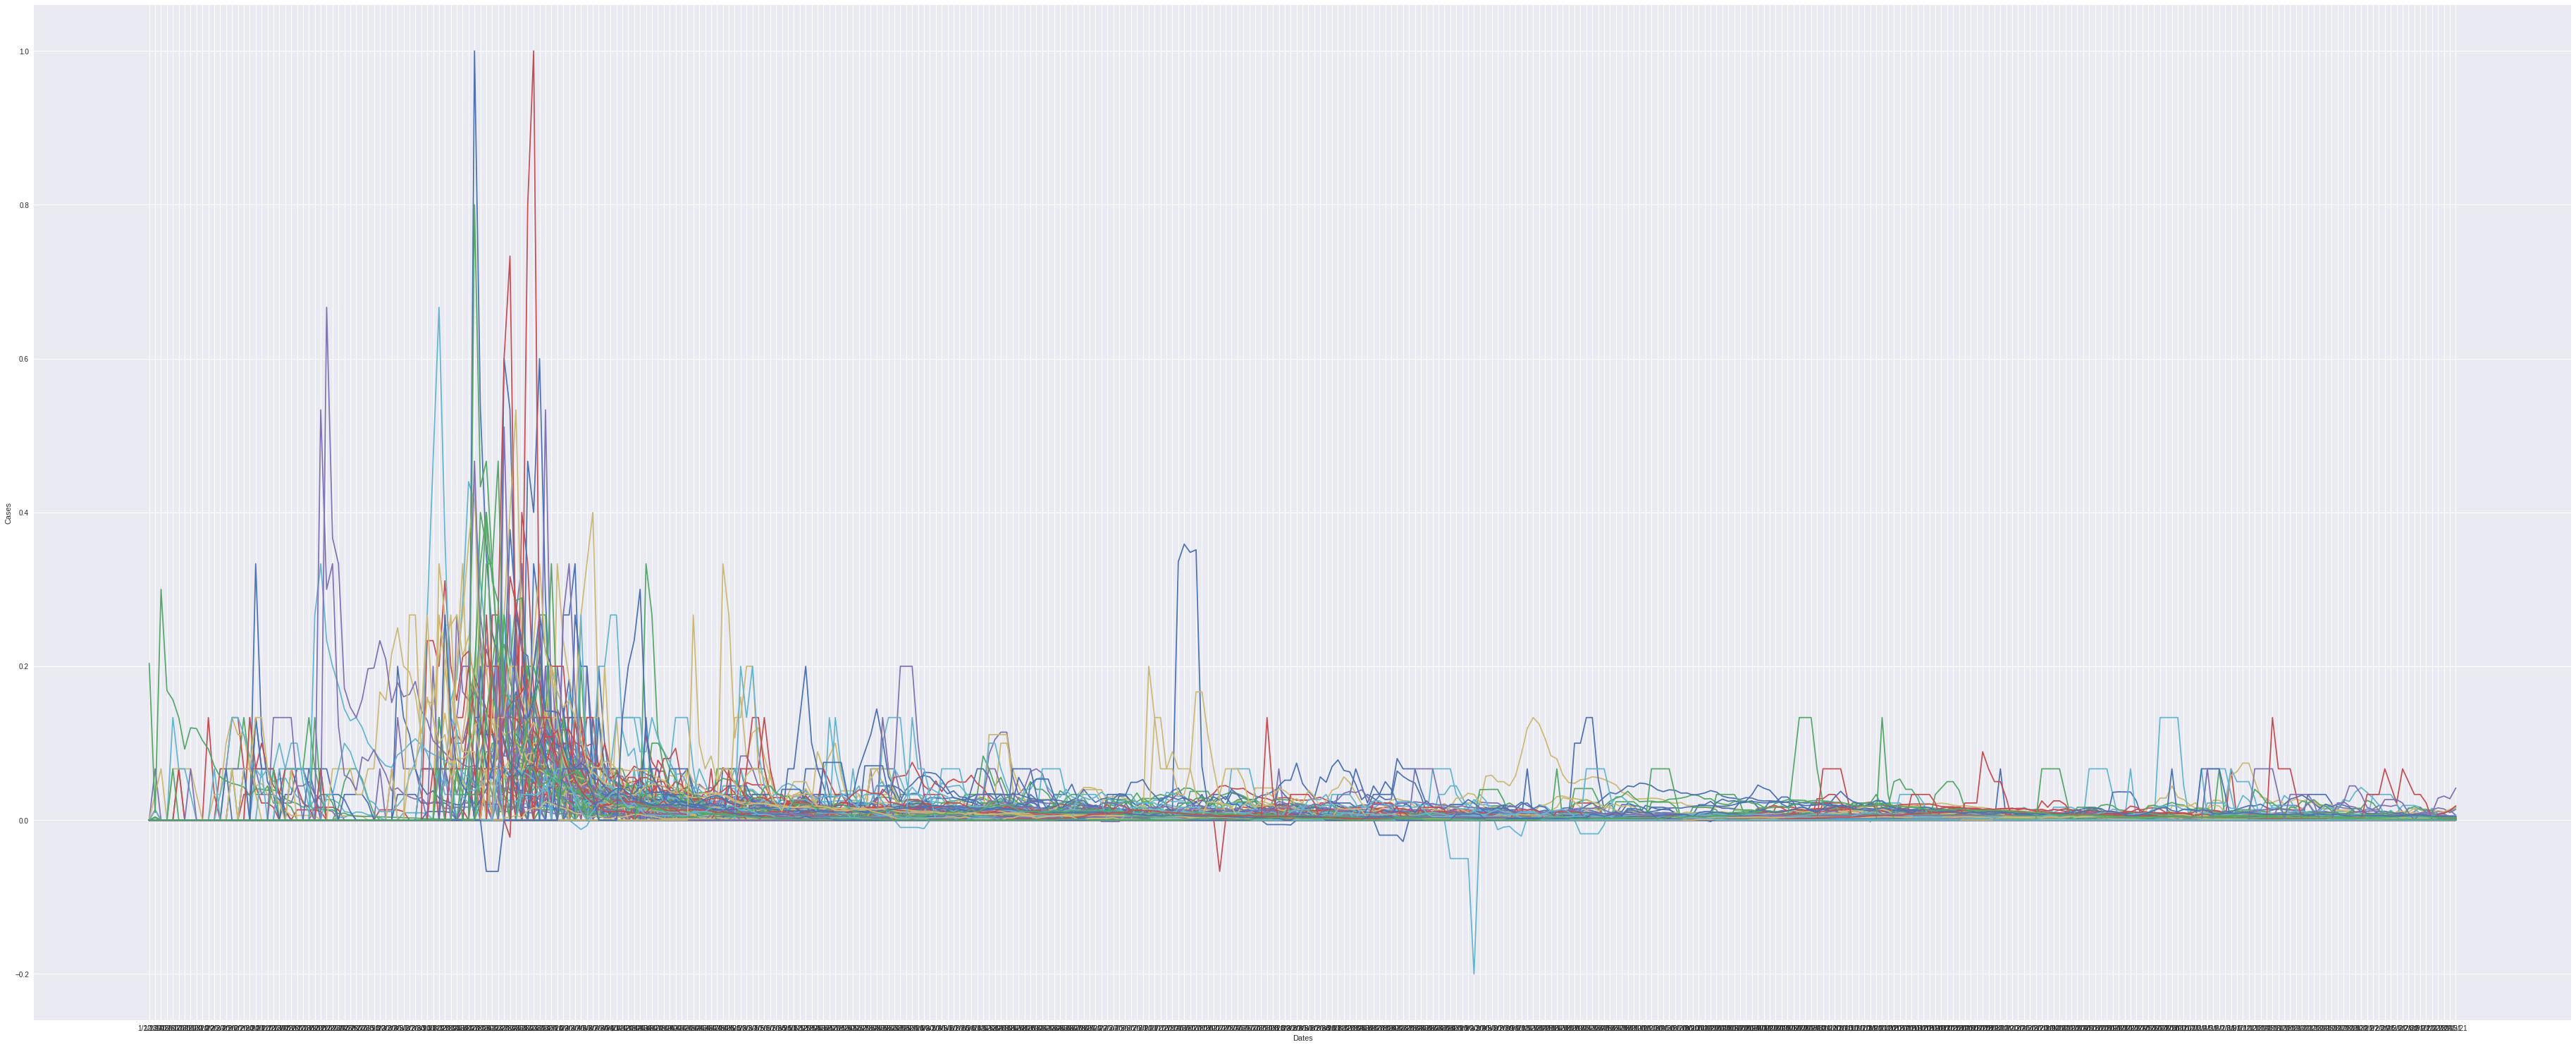

In [ ]:
filtered_dr = filtered_dr[~filtered_dr.area.str.contains("Diamond Princess")]
get_graphs(filtered_dr[filtered_dr.columns[:-1]], areas=filtered_dr['area'], startc=info_length+dates_length)

In [ ]:
df=filtered_dr.copy()
df=df.iloc[:, list(range(info_length)) + list(range(-dates_length,-1))]
df.shape

(212, 396)

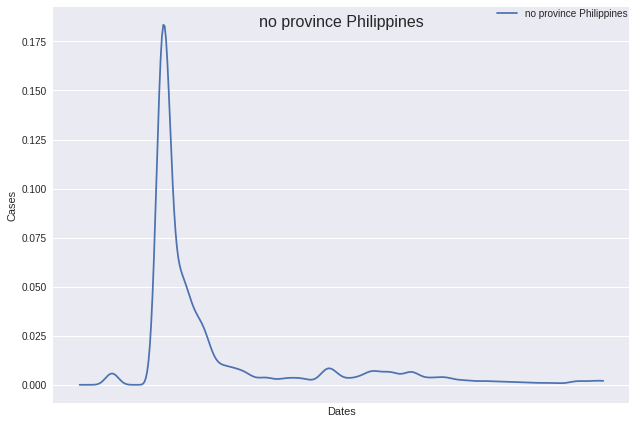

In [ ]:
smoothen_scaled_deaths = Moving_Ave_Stack(df, 7, 5)
get_graph(smoothen_scaled_deaths, country='Philippines')

In [ ]:
smoothen_scaled_deaths.head()

Province/State Country/Region       Lat  ...   2/13/21   2/14/21   2/15/21
0    no province    Afghanistan  33.93911  ...  0.000346  0.000313  0.000286
1    no province        Albania  41.15330  ...  0.002418  0.002499  0.002580
2    no province        Algeria  28.03390  ...  0.000420  0.000415  0.000410
3    no province        Andorra  42.50630  ...  0.002217  0.002116  0.002014
4    no province         Angola -11.20270  ...  0.001016  0.001010  0.001026

[5 rows x 396 columns]

In [ ]:
peak2 = smoothen_scaled_deaths[smoothen_scaled_deaths.columns[5:]].to_numpy().max()
peak2

0.2378602456382177

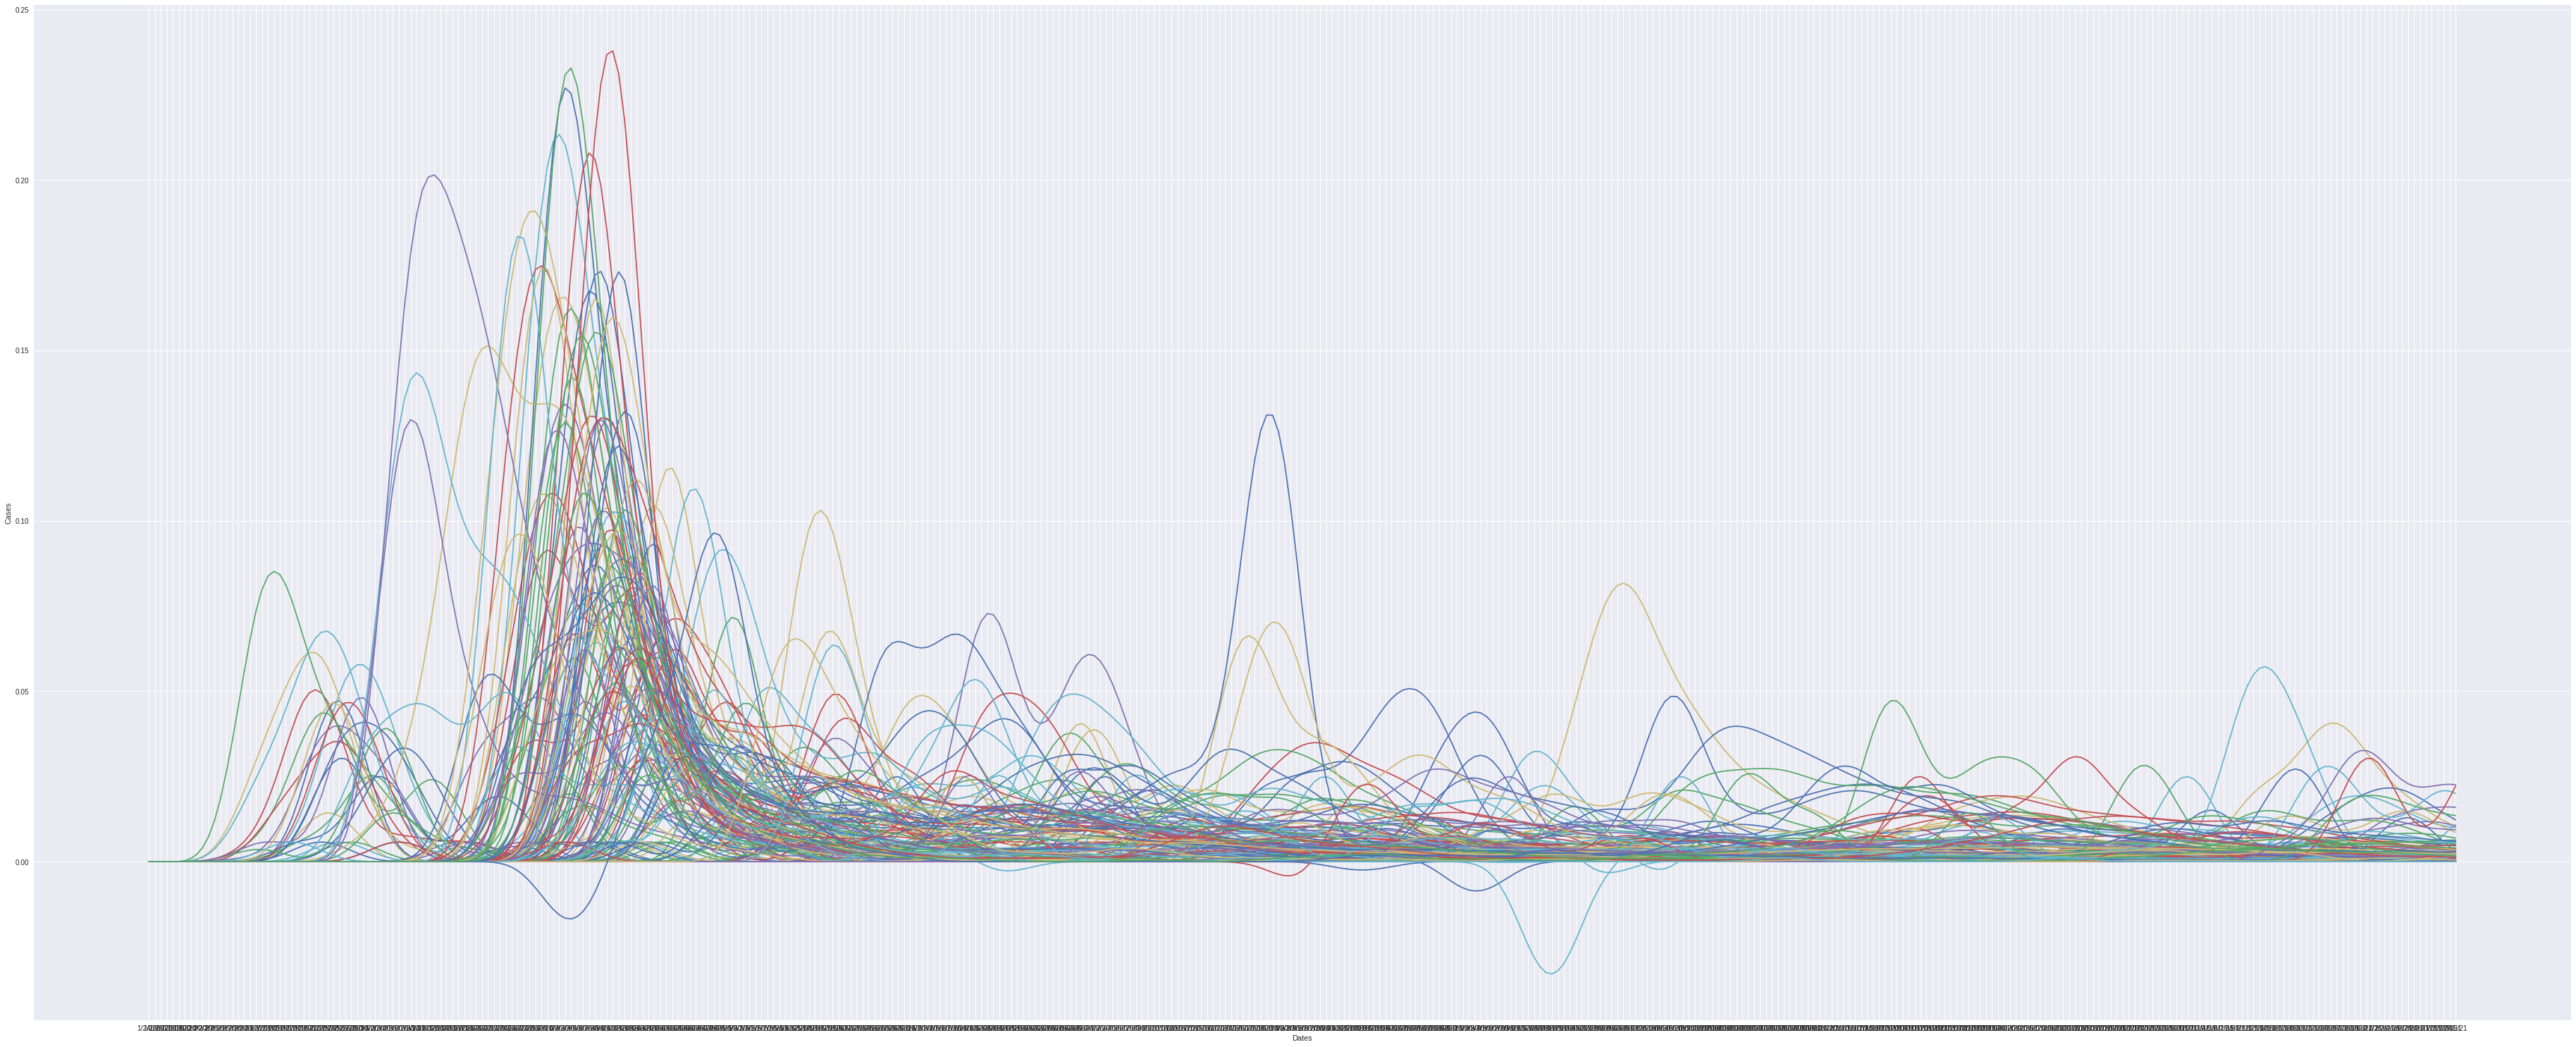

In [ ]:
get_graphs(smoothen_scaled_deaths, areas=smoothen_scaled_deaths['area'])

# Recoveries

In [ ]:
file_path = os.path.join(BASE_DIR, 'data/time_series_covid19_recovered_global.csv')
recovered = pd.read_csv(file_path)
recovered.head()

Province/State Country/Region       Lat  ...  2/14/21  2/15/21  2/16/21
0            NaN    Afghanistan  33.93911  ...  48395.0  48433.0  48514.0
1            NaN        Albania  41.15330  ...  56764.0  57736.0  58794.0
2            NaN        Algeria  28.03390  ...  75999.0  76168.0  76330.0
3            NaN        Andorra  42.50630  ...   9911.0   9965.0  10022.0
4            NaN         Angola -11.20270  ...  18795.0  18884.0  18929.0

[5 rows x 396 columns]

In [ ]:
recovered.shape

(214, 396)

In [ ]:
# Combine province/state and country into one column
recovered['Province/State']=recovered['Province/State'].fillna("no province")
recovered['area']=recovered['Province/State']+" "+recovered['Country/Region']
recovered.head()

Province/State Country/Region  ...  2/16/21                     area
0    no province    Afghanistan  ...  48514.0  no province Afghanistan
1    no province        Albania  ...  58794.0      no province Albania
2    no province        Algeria  ...  76330.0      no province Algeria
3    no province        Andorra  ...  10022.0      no province Andorra
4    no province         Angola  ...  18929.0       no province Angola

[5 rows x 397 columns]

In [ ]:
cols = recovered.columns.tolist()
cols = cols[:4] + cols[-1::] + cols[4:-1]
recovered = recovered[cols]
recovered.head()

Province/State Country/Region       Lat  ...  2/14/21  2/15/21  2/16/21
0    no province    Afghanistan  33.93911  ...  48395.0  48433.0  48514.0
1    no province        Albania  41.15330  ...  56764.0  57736.0  58794.0
2    no province        Algeria  28.03390  ...  75999.0  76168.0  76330.0
3    no province        Andorra  42.50630  ...   9911.0   9965.0  10022.0
4    no province         Angola -11.20270  ...  18795.0  18884.0  18929.0

[5 rows x 397 columns]

In [ ]:
columns = recovered.columns
# Copies the specified columns into a new Dataframe
daily_recovered = recovered.copy()
print(len(columns))

for i in range(6, len(columns)):
    daily = recovered[columns[i]] - recovered[columns[i-1]]
    daily_recovered[columns[i]]=daily

daily_recovered.head()

397


Province/State Country/Region       Lat  ...  2/14/21 2/15/21  2/16/21
0    no province    Afghanistan  33.93911  ...      3.0    38.0     81.0
1    no province        Albania  41.15330  ...    781.0   972.0   1058.0
2    no province        Algeria  28.03390  ...    183.0   169.0    162.0
3    no province        Andorra  42.50630  ...     43.0    54.0     57.0
4    no province         Angola -11.20270  ...      5.0    89.0     45.0

[5 rows x 397 columns]

## Normalize by population

In [ ]:
scaled_recovered=daily_recovered.copy()
#active_cases[active_cases.columns[:info_length+dates_length]].head()
scaled_recovered.shape

(214, 397)

In [ ]:
reco_rate = pd.merge(scaled_recovered, moved_scaled[moved_scaled.columns[4:6]], on='area')
reco_rate.head()

Province/State Country/Region       Lat  ...  2/15/21 2/16/21  populations
0    no province    Afghanistan  33.93911  ...     38.0    81.0     38928346
1    no province        Albania  41.15330  ...    972.0  1058.0      2877797
2    no province        Algeria  28.03390  ...    169.0   162.0     43851044
3    no province        Andorra  42.50630  ...     54.0    57.0        77265
4    no province         Angola -11.20270  ...     89.0    45.0     32866272

[5 rows x 398 columns]

In [ ]:
cols = reco_rate.columns.tolist()
cols = cols[:5] + cols[-1::] + cols[5:-1]
reco_rate = reco_rate[cols]
reco_rate.head()

Province/State Country/Region       Lat  ...  2/14/21 2/15/21  2/16/21
0    no province    Afghanistan  33.93911  ...      3.0    38.0     81.0
1    no province        Albania  41.15330  ...    781.0   972.0   1058.0
2    no province        Algeria  28.03390  ...    183.0   169.0    162.0
3    no province        Andorra  42.50630  ...     43.0    54.0     57.0
4    no province         Angola -11.20270  ...      5.0    89.0     45.0

[5 rows x 398 columns]

In [ ]:
for col in reco_rate.columns[6:]:
  reco_rate[col]=reco_rate[col]/reco_rate['populations']

reco_rate.head()

Province/State Country/Region       Lat  ...       2/14/21       2/15/21   2/16/21
0    no province    Afghanistan  33.93911  ...  7.706467e-08  9.761524e-07  0.000002
1    no province        Albania  41.15330  ...  2.713881e-04  3.377584e-04  0.000368
2    no province        Algeria  28.03390  ...  4.173219e-06  3.853956e-06  0.000004
3    no province        Andorra  42.50630  ...  5.565262e-04  6.988934e-04  0.000738
4    no province         Angola -11.20270  ...  1.521316e-07  2.707943e-06  0.000001

[5 rows x 398 columns]

In [ ]:
pd.set_option('use_inf_as_na', True)
for col in reco_rate.columns:
    reco_rate[col].replace([np.inf, -np.inf], np.nan)
    reco_rate[col].fillna(0, inplace=True)
reco_rate.head()

Province/State Country/Region       Lat  ...       2/14/21       2/15/21   2/16/21
0    no province    Afghanistan  33.93911  ...  7.706467e-08  9.761524e-07  0.000002
1    no province        Albania  41.15330  ...  2.713881e-04  3.377584e-04  0.000368
2    no province        Algeria  28.03390  ...  4.173219e-06  3.853956e-06  0.000004
3    no province        Andorra  42.50630  ...  5.565262e-04  6.988934e-04  0.000738
4    no province         Angola -11.20270  ...  1.521316e-07  2.707943e-06  0.000001

[5 rows x 398 columns]

In [ ]:
reco_rate.shape

(177, 398)

In [ ]:
NUM_DAYS = 5
info_length = 6
dates_length = 392
moving_ave_recovered = reco_rate[reco_rate.columns[:info_length+dates_length-1]].copy()
dates = reco_rate.columns[info_length:info_length+dates_length-1]

for idx, date in enumerate(dates):
  seven_days = dates[idx : idx+NUM_DAYS]
  moving_ave_recovered[date] = reco_rate.apply(lambda x: x[seven_days].mean(), axis=1)

moving_ave_recovered.head()

Province/State Country/Region  ...       2/14/21       2/15/21
0    no province    Afghanistan  ...  5.266086e-07  9.761524e-07
1    no province        Albania  ...  3.045733e-04  3.377584e-04
2    no province        Algeria  ...  4.013587e-06  3.853956e-06
3    no province        Andorra  ...  6.277098e-04  6.988934e-04
4    no province         Angola  ...  1.430037e-06  2.707943e-06

[5 rows x 397 columns]

In [ ]:
moving_ave_recovered.shape

(177, 397)

## Normalize by Peak

In [ ]:
for col in dates:
    moving_ave_recovered[col].replace([np.inf, -np.inf], np.nan)
    moving_ave_recovered[col].fillna(0, inplace=True)
moving_ave_recovered.head()

Province/State Country/Region  ...       2/14/21       2/15/21
0    no province    Afghanistan  ...  5.266086e-07  9.761524e-07
1    no province        Albania  ...  3.045733e-04  3.377584e-04
2    no province        Algeria  ...  4.013587e-06  3.853956e-06
3    no province        Andorra  ...  6.277098e-04  6.988934e-04
4    no province         Angola  ...  1.430037e-06  2.707943e-06

[5 rows x 397 columns]

In [ ]:
peak3 = moving_ave_recovered[dates].to_numpy().max()
peak3

0.012061013890383773

In [ ]:

for col in dates:
  moving_ave_recovered[col] = moving_ave_recovered[col] / peak3

moving_ave_recovered.head()

Province/State Country/Region       Lat  ...   2/13/21   2/14/21   2/15/21
0    no province    Afghanistan  33.93911  ...  0.000031  0.000044  0.000081
1    no province        Albania  41.15330  ...  0.023942  0.025253  0.028004
2    no province        Algeria  28.03390  ...  0.000340  0.000333  0.000320
3    no province        Andorra  42.50630  ...  0.047216  0.052045  0.057946
4    no province         Angola -11.20270  ...  0.000082  0.000119  0.000225

[5 rows x 397 columns]

In [ ]:
moving_ave_recovered[dates].to_numpy().max()

1.0

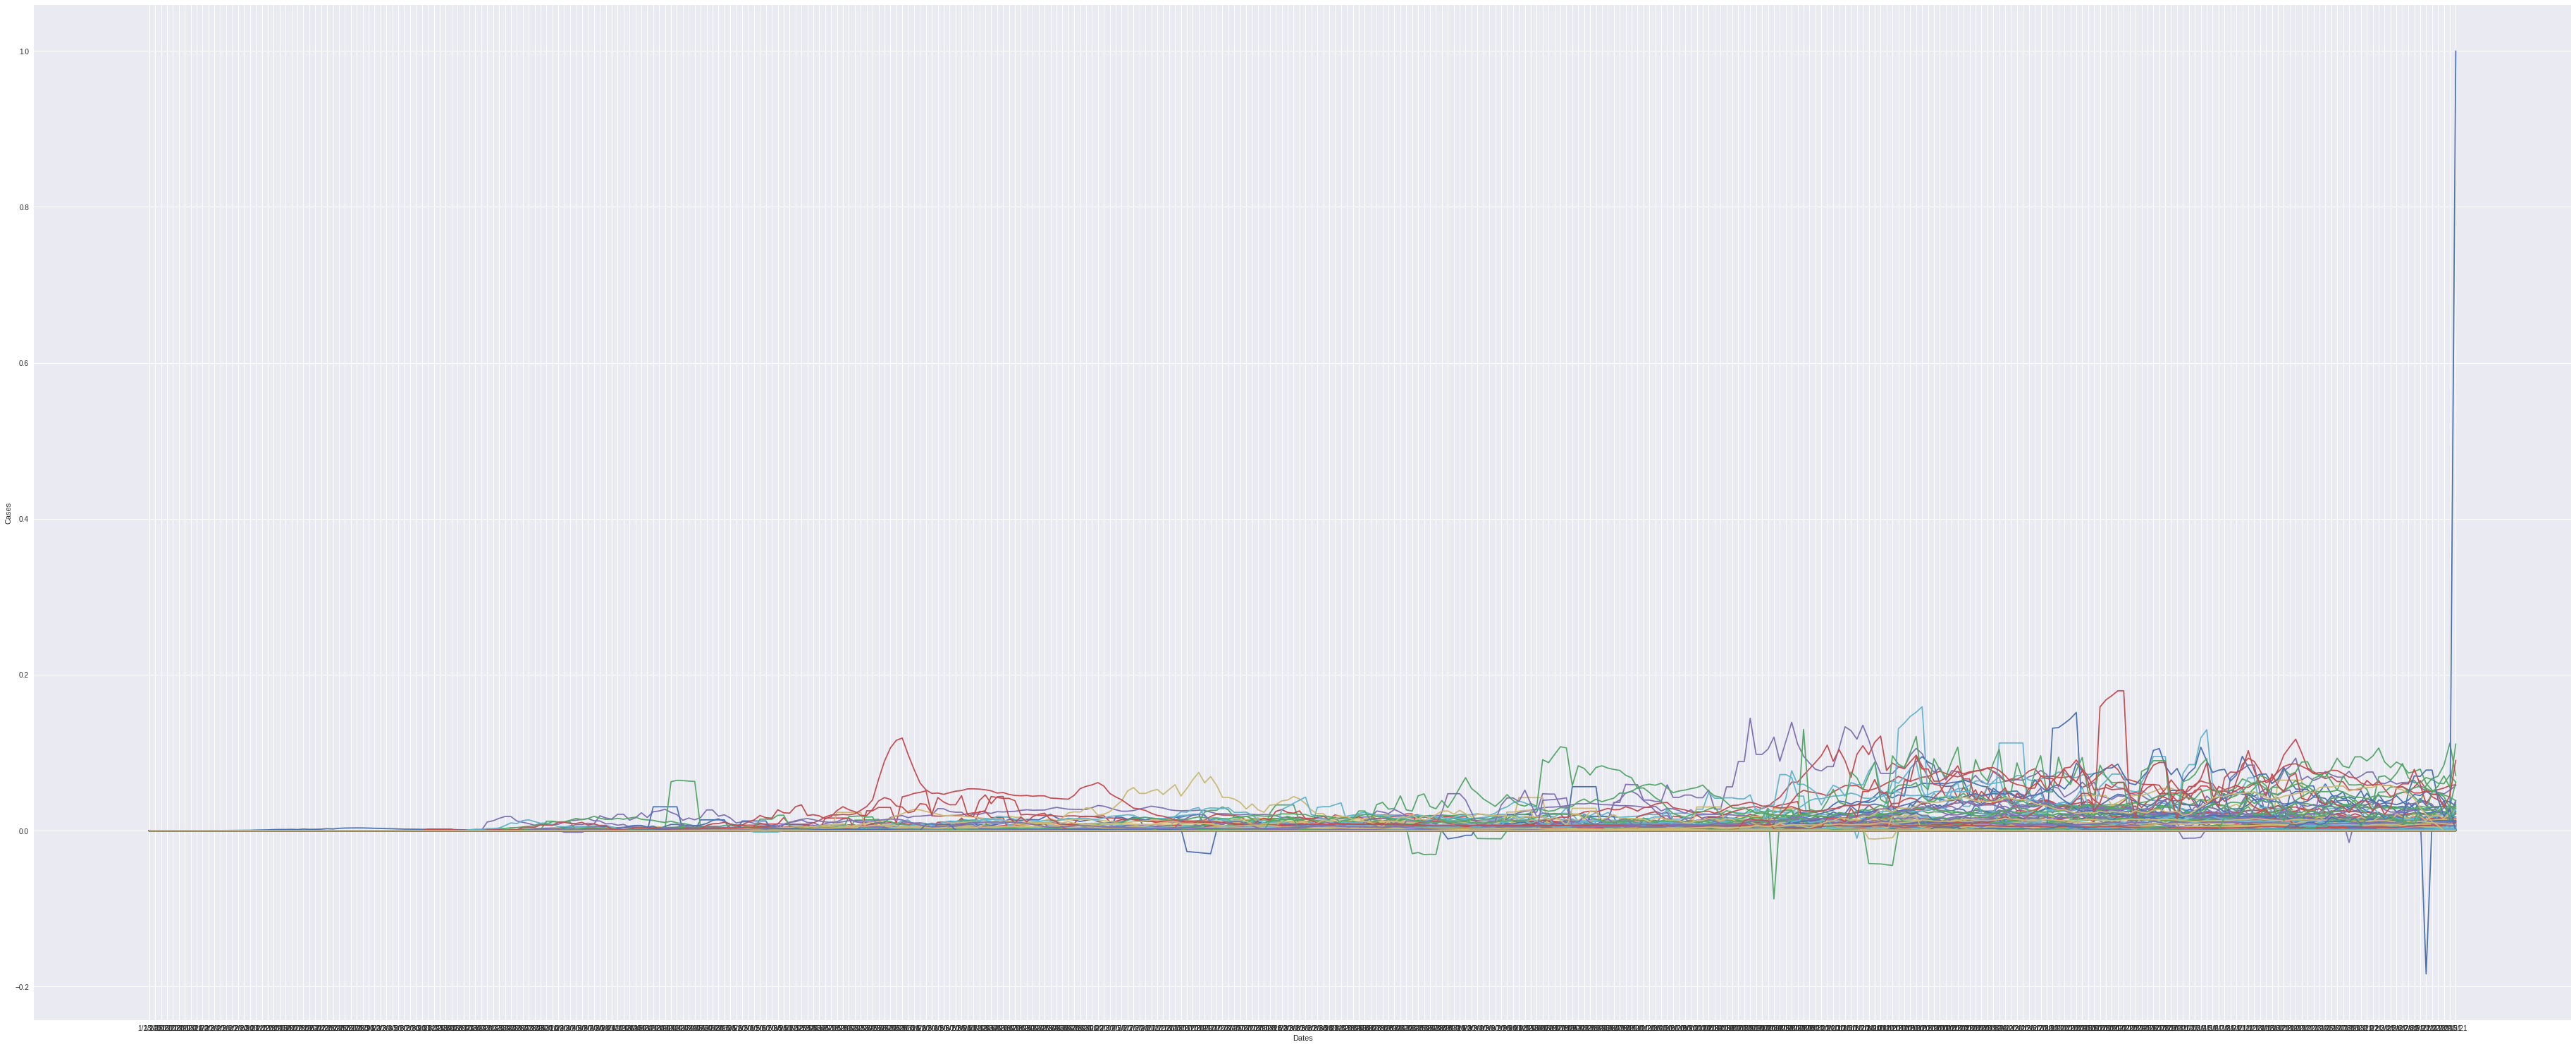

In [ ]:
moving_ave_recovered = moving_ave_recovered[~moving_ave_recovered.area.str.contains("Diamond Princess")]
get_graphs(moving_ave_recovered, areas=scaled_deaths['area'])

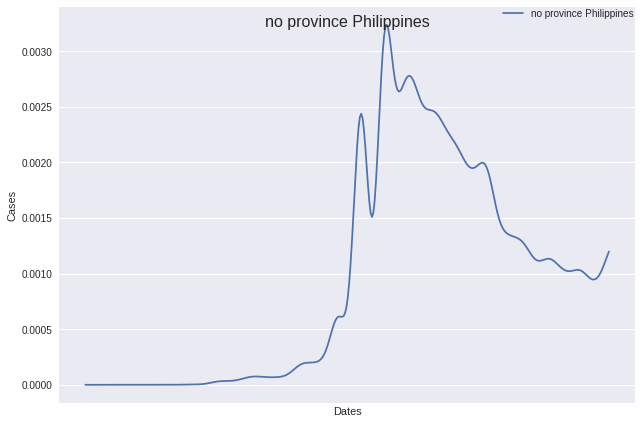

In [ ]:
smoothen_recovered = Moving_Ave_Stack(moving_ave_recovered, 7, 6)
get_graph(smoothen_recovered, country='Philippines')

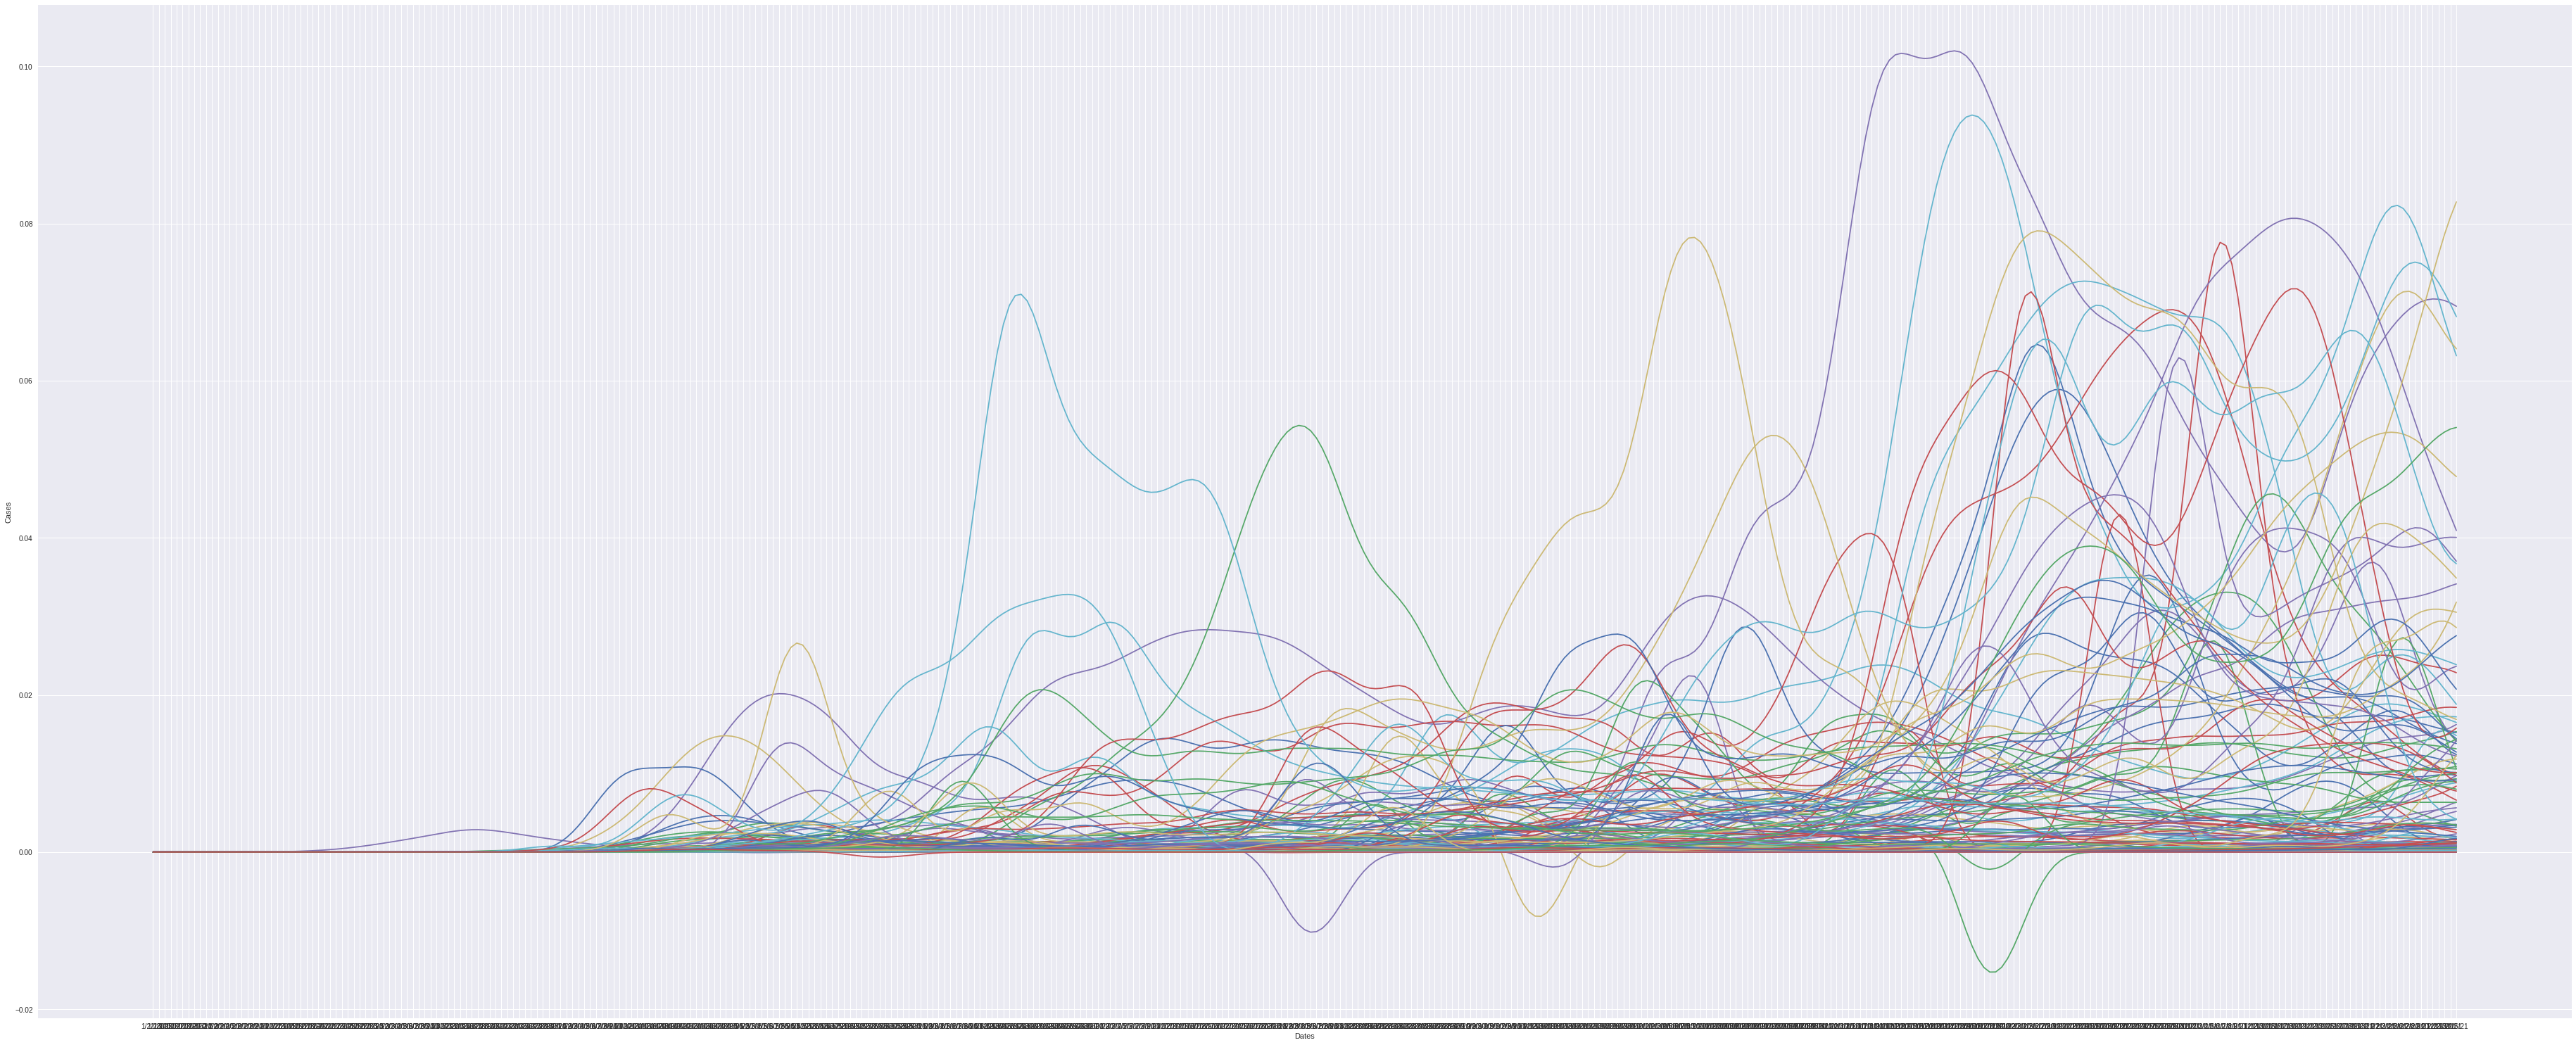

In [ ]:
get_graphs(smoothen_recovered, areas=smoothen_recovered['area'], startc=6)

In [ ]:
peak3 = smoothen_recovered[dates].to_numpy().max()
peak3

0.10198376840597112

In [ ]:
smoothen_scaled_deaths.to_csv(os.path.join(BASE_DIR, 'data/new_normalized_deaths.csv'))

In [ ]:
smoothen_recovered.to_csv(os.path.join(BASE_DIR, 'data/new_normalized_recovered.csv'))

# ADDING SHIFTS

## Load All Datasets

In [ ]:
confi = pd.read_csv(os.path.join(BASE_DIR, 'data/new_normalized_confirmed.csv'), index_col=0)
dea = pd.read_csv(os.path.join(BASE_DIR, 'data/new_normalized_deaths.csv'), index_col=0)
# reco = pd.read_csv(os.path.join(BASE_DIR, 'data/new_normalized_recovered.csv'), index_col=0)

dea.head()

Province/State Country/Region       Lat  ...   4/16/21   4/17/21   4/18/21
0    no province    Afghanistan  33.93911  ...  0.003446  0.003578  0.003644
1    no province        Albania  41.15330  ...  0.108483  0.106209  0.104009
2    no province        Algeria  28.03390  ...  0.002954  0.002961  0.002966
3    no province      Argentina -38.41610  ...  0.113878  0.119493  0.126255
4    no province        Armenia  40.06910  ...  0.233164  0.237354  0.241448

[5 rows x 459 columns]

In [ ]:
# Combine all datasets into one

# Deaths
combined = confi.copy()
dea_cols = dea.columns[4:].tolist()
dea_cols = dea_cols[0:1]+dea_cols[2:]
combined = pd.merge(confi, dea[dea_cols], on=['area'])

# # Recoveries
# reco_cols = reco.columns[4:].tolist()
# reco_cols = reco_cols[0:1]+reco_cols[2:]
# combined = pd.merge(combined, reco[reco_cols], on=['area'])
#combined.head()

print(combined.shape)
combined.head()

(140, 912)


Province/State Country/Region       Lat  ...  4/16/21_y  4/17/21_y 4/18/21_y
0    no province    Afghanistan  33.93911  ...   0.003446   0.003578  0.003644
1    no province        Albania  41.15330  ...   0.108483   0.106209  0.104009
2    no province        Algeria  28.03390  ...   0.002954   0.002961  0.002966
3    no province      Argentina -38.41610  ...   0.113878   0.119493  0.126255
4    no province        Armenia  40.06910  ...   0.233164   0.237354  0.241448

[5 rows x 912 columns]

In [ ]:
get_graphs(combined, areas = combined['area'])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:

combined[combined.columns[info_length+dates_length:info_length+dates_length+dates_length-1]].head()

1/22/20_y  1/23/20_y  1/24/20_y  ...  4/15/21_y  4/16/21_y  4/17/21_y
0        0.0        0.0        0.0  ...   0.003256   0.003446   0.003578
1        0.0        0.0        0.0  ...   0.110964   0.108483   0.106209
2        0.0        0.0        0.0  ...   0.002945   0.002954   0.002961
3        0.0        0.0        0.0  ...   0.109498   0.113878   0.119493
4        0.0        0.0        0.0  ...   0.229035   0.233164   0.237354

[5 rows x 452 columns]

## Normalize by Peaks

In [ ]:
info_length = 6
dates_length = combined.columns[info_length:].shape[0] // 2
confirmed_columns = combined.columns[info_length:info_length+dates_length]
death_columns = combined.columns[info_length+dates_length:]
death_columns

Index(['1/22/20_y', '1/23/20_y', '1/24/20_y', '1/25/20_y', '1/26/20_y',
       '1/27/20_y', '1/28/20_y', '1/29/20_y', '1/30/20_y', '1/31/20_y',
       ...
       '4/9/21_y', '4/10/21_y', '4/11/21_y', '4/12/21_y', '4/13/21_y',
       '4/14/21_y', '4/15/21_y', '4/16/21_y', '4/17/21_y', '4/18/21_y'],
      dtype='object', length=453)

In [ ]:
combined.head()

Province/State Country/Region       Lat  ...  4/16/21_y  4/17/21_y 4/18/21_y
0    no province    Afghanistan  33.93911  ...   0.003446   0.003578  0.003644
1    no province        Albania  41.15330  ...   0.108483   0.106209  0.104009
2    no province        Algeria  28.03390  ...   0.002954   0.002961  0.002966
3    no province      Argentina -38.41610  ...   0.113878   0.119493  0.126255
4    no province        Armenia  40.06910  ...   0.233164   0.237354  0.241448

[5 rows x 912 columns]

In [ ]:
peak = combined[confirmed_columns].to_numpy().max()
peak

1.0

In [ ]:
for cols in confirmed_columns:
    combined[cols] = combined[cols]/peak
peak = combined[confirmed_columns].to_numpy().max()
peak

1.0

In [ ]:
# Get the peak of the subset of DEATHS
peak_deaths = combined[death_columns].to_numpy().max()
peak_deaths

1.0

In [ ]:
for cols in death_columns:
    combined[cols] = combined[cols]/peak_deaths
peak = combined[death_columns].to_numpy().max()
peak

1.0

In [ ]:
combined[death_columns].head()

1/22/20_y  1/23/20_y  1/24/20_y  ...  4/16/21_y  4/17/21_y  4/18/21_y
0        0.0        0.0        0.0  ...   0.003446   0.003578   0.003644
1        0.0        0.0        0.0  ...   0.108483   0.106209   0.104009
2        0.0        0.0        0.0  ...   0.002954   0.002961   0.002966
3        0.0        0.0        0.0  ...   0.113878   0.119493   0.126255
4        0.0        0.0        0.0  ...   0.233164   0.237354   0.241448

[5 rows x 453 columns]

## Normalizing by Recoveries
Remove since we are not including recoveries anymore

In [ ]:
peak = combined[combined.columns[info_length+dates_length+dates_length-1:]].to_numpy().max()
peak

0.10198376840597112

In [ ]:
for cols in combined.columns[info_length+dates_length+dates_length-1:]:
    combined[cols] = combined[cols]/peak
peak = combined[combined.columns[info_length+dates_length+dates_length-1:]].to_numpy().max()
peak

1.0

## Determine Shift Thresholds

In [ ]:
get_graphs(combined, areas = combined['area'])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Get the index of the last column belonging to the CONFIRMED subset
last_index_confirmed = dates_length+info_length
combined[confirmed_columns].quantile([0.33, 0.66])

1/22/20_x  1/23/20_x  1/24/20_x  ...  4/16/21_x  4/17/21_x  4/18/21_x
0.33        0.0        0.0        0.0  ...   0.018699   0.019072   0.019900
0.66        0.0        0.0        0.0  ...   0.105680   0.109822   0.111816

[2 rows x 453 columns]

In [ ]:
# Get only the quantile of the confirmed
dates = combined[confirmed_columns]
vals = dates.to_numpy().flatten()
vals = vals[vals > 0]

In [ ]:
num_countries = combined.shape[0]
shifts = [[] for i in range(num_countries)]
lows = np.quantile(vals, 0.33)
mids = np.quantile(vals, 0.66)
print(lows, mids)

0.0027179017589886033 0.03287950816603294


In [ ]:
rown=0
for i in combined.iterrows():
    cur_tmp='low'
    next_tmp='low'
    same_counter=15
    for j in range(info_length,last_index_confirmed):
        if i[1][j]<lows:
            next_tmp='low'
        elif i[1][j]<mids:
            next_tmp='mid'
        else:
            next_tmp='high'
        if cur_tmp==next_tmp:
            same_counter=same_counter+1
            if same_counter>=15:
                shifts[rown].append(next_tmp)
                cur_tmp=next_tmp
                same_counter=0
        else:
            shifts[rown].append(next_tmp)
            cur_tmp=next_tmp
            same_counter=0
    rown=rown+1

In [ ]:
vector_shifts=[[] for i in range(num_countries)]
shift_change = {'lowlow':0, 'lowmid':1, 'lowhigh':6, 'midlow':2, 'midmid':5, 'midhigh':7, 'highmid':4, 'highhigh':8, 'highlow':3}

In [ ]:
for i in range(0, num_countries):
    for j in range(1, len(shifts[i])):
        vector_shifts[i].append(shift_change[shifts[i][j-1]+shifts[i][j]])

In [ ]:
number_of_shifts = [len(i) for i in shifts]

In [ ]:
number_of_shifts_added = combined.copy()
number_of_shifts_added['shifts']=number_of_shifts
number_of_shifts_added.head()

Province/State Country/Region       Lat  ...  4/17/21_y  4/18/21_y shifts
0    no province    Afghanistan  33.93911  ...   0.003578   0.003644     33
1    no province        Albania  41.15330  ...   0.106209   0.104009     33
2    no province        Algeria  28.03390  ...   0.002961   0.002966     33
3    no province      Argentina -38.41610  ...   0.119493   0.126255     32
4    no province        Armenia  40.06910  ...   0.237354   0.241448     34

[5 rows x 913 columns]

In [ ]:
max_shifts = max(number_of_shifts)
max_shifts

36

In [ ]:
for i in vector_shifts:
    while(len(i))<max_shifts:
        i.append(-1)

In [ ]:
shifts_added = number_of_shifts_added.copy()
for i in range(1, max_shifts+1):
    name='shift '+str(i)
    tmp=[]
    for j in vector_shifts:
        tmp.append(j[i-1])
    shifts_added[name] = tmp
shifts_added[shifts_added.columns[-max_shifts:]].head()

shift 1  shift 2  shift 3  shift 4  ...  shift 33  shift 34  shift 35  shift 36
0        0        0        0        0  ...        -1        -1        -1        -1
1        0        0        0        0  ...        -1        -1        -1        -1
2        0        0        0        0  ...        -1        -1        -1        -1
3        0        0        0        0  ...        -1        -1        -1        -1
4        0        0        0        0  ...         8        -1        -1        -1

[5 rows x 36 columns]

In [ ]:
shifts_added.to_csv(os.path.join(BASE_DIR, 'data/combined_added_shifts.csv'))

## Do the same for deaths

In [ ]:
combined[death_columns].quantile([0.33, 0.66])

1/22/20_y  1/23/20_y  1/24/20_y  ...  2/13/21_y  2/14/21_y  2/15/21_y
0.33        0.0        0.0        0.0  ...   0.000693   0.000652   0.000627
0.66        0.0        0.0        0.0  ...   0.017346   0.017270   0.017552

[2 rows x 391 columns]

In [ ]:
dates = combined[death_columns]
vals = dates.to_numpy().flatten()
vals = vals[vals > 0]

In [ ]:
num_countries = combined.shape[0]
shifts = [[] for i in range(num_countries)]
lows = np.quantile(vals, 0.33)
mids = np.quantile(vals, 0.66)
print(lows, mids)

0.00022386958104862932 0.0040988330145829656


In [ ]:
rown=0
for i in combined.iterrows():
    cur_tmp='low'
    next_tmp='low'
    same_counter=15
    for j in range(last_index_confirmed, last_index_confirmed + dates_length):
        if i[1][j]<lows:
            next_tmp='low'
        elif i[1][j]<mids:
            next_tmp='mid'
        else:
            next_tmp='high'
        if cur_tmp==next_tmp:
            same_counter=same_counter+1
            if same_counter>=15:
                shifts[rown].append(next_tmp)
                cur_tmp=next_tmp
                same_counter=0
        else:
            shifts[rown].append(next_tmp)
            cur_tmp=next_tmp
            same_counter=0
    rown=rown+1

In [ ]:
vector_shifts=[[] for i in range(num_countries)]
shift_change = {'lowlow':0, 'lowmid':1, 'lowhigh':6, 'midlow':2, 'midmid':5, 'midhigh':7, 'highmid':4, 'highhigh':8, 'highlow':3}

In [ ]:
for i in range(0, num_countries):
    for j in range(1, len(shifts[i])):
        vector_shifts[i].append(shift_change[shifts[i][j-1]+shifts[i][j]])

In [ ]:
number_of_shifts = [len(i) for i in shifts]

In [ ]:
number_of_shifts_added = combined.copy()
number_of_shifts_added['shifts']=number_of_shifts
number_of_shifts_added.head()

Province/State Country/Region       Lat  ...  2/14/21_y  2/15/21_y shifts
0    no province    Afghanistan  33.93911  ...   0.000653   0.000584     28
1    no province        Albania  41.15330  ...   0.030964   0.032269     28
2    no province        Algeria  28.03390  ...   0.000785   0.000774     27
3    no province        Andorra  42.50630  ...   0.082737   0.079767     36
4    no province         Angola -11.20270  ...   0.000401   0.000391     28

[5 rows x 789 columns]

In [ ]:
max_shifts = max(number_of_shifts)
max_shifts

38

In [ ]:
for i in vector_shifts:
    while(len(i))<max_shifts:
        i.append(-1)

In [ ]:
shifts_added = number_of_shifts_added.copy()
for i in range(1, max_shifts+1):
    name='shift '+str(i)
    tmp=[]
    for j in vector_shifts:
        tmp.append(j[i-1])
    shifts_added[name] = tmp
shifts_added[shifts_added.columns[-max_shifts:]].head()

shift 1  shift 2  shift 3  shift 4  ...  shift 35  shift 36  shift 37  shift 38
0        0        0        0        0  ...        -1        -1        -1        -1
1        0        0        0        0  ...        -1        -1        -1        -1
2        0        0        0        0  ...        -1        -1        -1        -1
3        0        0        0        0  ...         8        -1        -1        -1
4        0        0        0        0  ...        -1        -1        -1        -1

[5 rows x 38 columns]

In [ ]:
shifts_added.to_csv(os.path.join(BASE_DIR, 'data/combined_added_shifts_deaths.csv'))

## Recoveries
Remove since we're excluding them now

In [ ]:
combined[combined.columns[2*last_index_confirmed-6:3*last_index_confirmed-12]].quantile([0.33, 0.66])

1/22/20  1/23/20  1/24/20  ...   2/13/21   2/14/21   2/15/21
0.33      0.0      0.0      0.0  ...  0.002483  0.002488  0.002483
0.66      0.0      0.0      0.0  ...  0.076030  0.078209  0.076528

[2 rows x 391 columns]

In [ ]:
dates = combined[combined.columns[2*last_index_confirmed-6:3*last_index_confirmed-12]]
vals = dates.to_numpy().flatten()
vals = vals[vals > 0]

In [ ]:
num_countries = combined.shape[0]
shifts = [[] for i in range(num_countries)]
lows = np.quantile(vals, 0.33)
mids = np.quantile(vals, 0.66)
print(lows, mids)

0.0004425328623681252 0.010210190464689706


In [ ]:
rown=0
for i in combined.iterrows():
    cur_tmp='low'
    next_tmp='low'
    same_counter=15
    for j in range(2*last_index_confirmed-6, 3*last_index_confirmed-12):
        if i[1][j]<lows:
            next_tmp='low'
        elif i[1][j]<mids:
            next_tmp='mid'
        else:
            next_tmp='high'
        if cur_tmp==next_tmp:
            same_counter=same_counter+1
            if same_counter>=15:
                shifts[rown].append(next_tmp)
                cur_tmp=next_tmp
                same_counter=0
        else:
            shifts[rown].append(next_tmp)
            cur_tmp=next_tmp
            same_counter=0
    rown=rown+1

In [ ]:
vector_shifts=[[] for i in range(num_countries)]
shift_change = {'lowlow':0, 'lowmid':1, 'lowhigh':6, 'midlow':2, 'midmid':5, 'midhigh':7, 'highmid':4, 'highhigh':8, 'highlow':3}

In [ ]:
for i in range(0, num_countries):
    for j in range(1, len(shifts[i])):
        vector_shifts[i].append(shift_change[shifts[i][j-1]+shifts[i][j]])

In [ ]:
number_of_shifts = [len(i) for i in shifts]

In [ ]:
number_of_shifts_added = combined.copy()
number_of_shifts_added['shifts']=number_of_shifts
number_of_shifts_added.head()

Province/State Country/Region       Lat  ...   2/14/21   2/15/21 shifts
0    no province    Afghanistan  33.93911  ...  0.001674  0.001526     28
1    no province        Albania  41.15330  ...  0.147771  0.150433     27
2    no province        Algeria  28.03390  ...  0.003646  0.003632     27
3    no province        Andorra  42.50630  ...  0.685395  0.681212     29
4    no province         Angola -11.20270  ...  0.002401  0.002315     29

[5 rows x 1180 columns]

In [ ]:
max_shifts = max(number_of_shifts)
max_shifts

33

In [ ]:
for i in vector_shifts:
    while(len(i))<max_shifts:
        i.append(-1)

In [ ]:
shifts_added = number_of_shifts_added.copy()
for i in range(1, max_shifts+1):
    name='shift '+str(i)
    tmp=[]
    for j in vector_shifts:
        tmp.append(j[i-1])
    shifts_added[name] = tmp
shifts_added[shifts_added.columns[-max_shifts:]].head()

shift 1  shift 2  shift 3  shift 4  ...  shift 30  shift 31  shift 32  shift 33
0        0        0        0        0  ...        -1        -1        -1        -1
1        0        0        0        0  ...        -1        -1        -1        -1
2        0        0        0        0  ...        -1        -1        -1        -1
3        0        0        0        0  ...        -1        -1        -1        -1
4        0        0        0        0  ...        -1        -1        -1        -1

[5 rows x 33 columns]

In [ ]:
shifts_added.to_csv(os.path.join(BASE_DIR, 'data/combined_added_shifts_recoveries.csv'))